In [2]:
import time, datetime
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import odeint
from scipy.optimize import minimize

In [3]:
df1 = pd.read_excel('./data/timeline.xlsx')
df1 = df1.fillna(0)
df1

,日期,累计确诊,治愈人数,死亡人数
0,2020-01-22,557,30,17
1,2020-01-23,657,32,18
2,2020-01-24,944,39,26
3,2020-01-25,1437,42,42
4,2020-01-26,2116,56,56
...,...,...,...,...
556,2021-07-31 00:00:00,198147331,129560044,4217149
557,2021-08-01 00:00:00,198631080,129848929,4224514
558,2021-08-02 00:00:00,199189076,130130355,4232527
559,2021-08-03 00:00:00,199819252,130431150,4242915


In [4]:
# 疫情高峰时期
a = (df1['累计确诊'] - df1.shift(1)['累计确诊']).iloc[1:].tolist()
df1.iloc[a.index(max((df1['累计确诊'] - df1.shift(1)['累计确诊']).iloc[1:])) + 1]

日期      2020-12-10
累计确诊      70439372
治愈人数      44887039
死亡人数       1638107
Name: 323, dtype: object

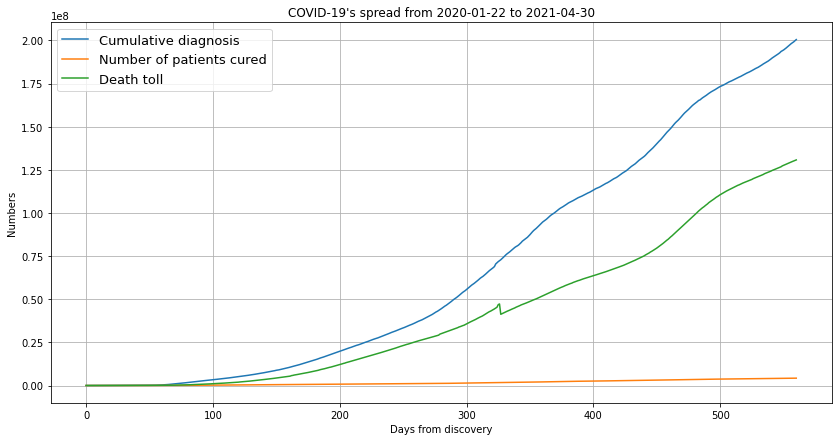

In [5]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df1.index, df1['累计确诊'], label='Cumulative diagnosis')
ax.plot(df1.index, df1['死亡人数'], label='Number of patients cured')
ax.plot(df1.index, df1['治愈人数'], label='Death toll')
ax.set_xlabel('Days from discovery')
ax.set_ylabel('Numbers')
ax.legend(fontsize=13)
ax.set_title("COVID-19's spread from 2020-01-22 to 2021-04-30")
ax.grid(True)
plt.show()

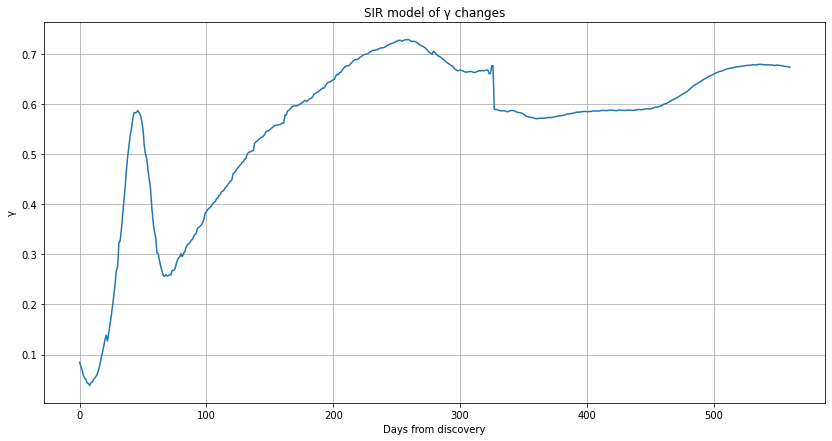

In [6]:
gammaguess = (df1["治愈人数"] + df1["死亡人数"]) / df1["累计确诊"]
gamma = gammaguess.mean()
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df1.index, gammaguess)
ax.set_title("SIR model of γ changes")
ax.set_xlabel('Days from discovery')
ax.set_ylabel('γ')
ax.grid(True)
plt.show()

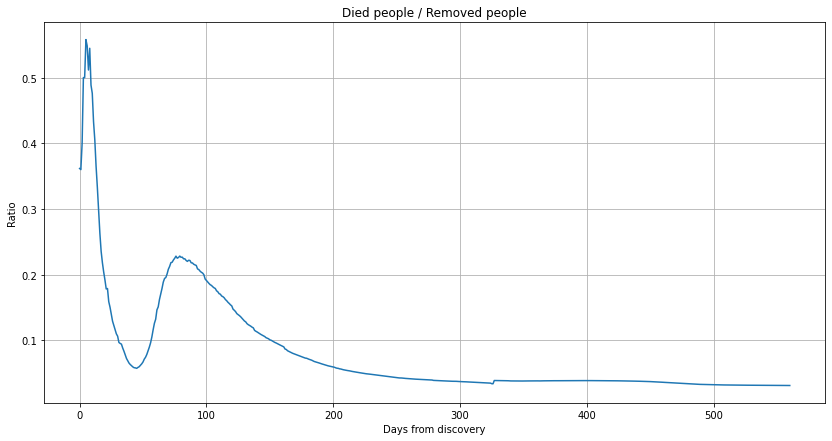

In [7]:
'''
死亡人数比移除人数比例
'''
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df1.index, df1['死亡人数'] / (df1['治愈人数'] + df1['死亡人数']))
ax.set_xlabel('Days from discovery')
ax.set_ylabel('Ratio')
ax.set_title("Died people / Removed people")
ax.grid(True)
plt.show()

In [10]:
'''
SIR模型的参数确定
'''
class estimationInfectionProb():
    def __init__(self, estUsedTimeIndexBox, nContact, gamma):
        self.timeRange = np.array([i for i in range(estUsedTimeIndexBox[0], estUsedTimeIndexBox[1] + 1)])
        self.nContact, self.gamma = nContact, gamma
        self.dataStartTimeStep = 0

    def setInitSolution(self, x0):
        self.x0 = 0.04

    def costFunction(self, infectionProb):
        res = np.array(np.exp((infectionProb * self.nContact - self.gamma) * self.timeRange) - \
                       df1.loc[self.timeRange - self.dataStartTimeStep, '累计确诊'])
        return (res ** 2).sum() / self.timeRange.size

    def optimize(self):
        self.solution = minimize(self.costFunction, self.x0, method='nelder-mead', options={'xtol': 1e-8, 'disp': False})
        return self.getSolution()

    def getSolution(self):
        return self.solution.x

    def getBasicReproductionNumber(self):
        self.basicReproductionNumber = self.nContact * self.solution.x[0] / (self.gamma)
        print("basic reproduction number:", self.basicReproductionNumber)
        return self.basicReproductionNumber


In [11]:
start_time = df1['日期'][0]
end_time = str(df1['日期'][max(df1.index)])[:-9]
# print(end_time[:-9])
nContact, gamma = int(5), 1/14
died_cure_radio = 0.02
t = np.arange(0, 800)
N = 68415007
S0 = 1 - 0.000000082     #根据治愈患者第一次出现的时间计算的比例
R0 = 2.428571428571429e-9
I0 = 7.957142857142857e-8

startTime = datetime.datetime.strptime(start_time, "%Y-%m-%d")
estUsedTimeBox = [datetime.datetime.strptime(start_time, "%Y-%m-%d"),
                  datetime.datetime.strptime(end_time, "%Y-%m-%d")]
estUsedTimeIndexBox = [(t - startTime).days for t in estUsedTimeBox]
estInfectionProb = estimationInfectionProb(estUsedTimeIndexBox, nContact, gamma)
estInfectionProb.setInitSolution(0.04)
infectionProb = estInfectionProb.optimize()
# SIR参数
beta = float(infectionProb) * nContact
σ = beta / gamma
print("beta={},gama={},σ={}".format(beta, gamma, σ))

beta=0.10659869346767642,gama=0.07142857142857142,σ=1.49238170854747


疫情结束的时间:2022-04-01 00:00:00,最终感染的人数:4217840,因为新冠疫情最终死亡的人数:790596


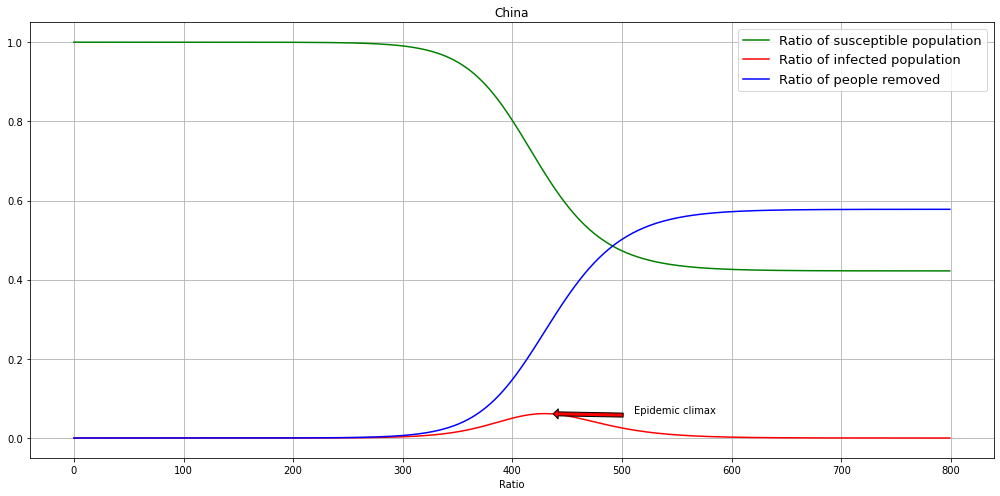

In [12]:
'''
SIR模型的微分方程
'''
def SIR(sir, t, beta, gamma):
    S, I, R = sir
    dsdt = - beta * S * I
    didt = beta * S * I - gamma * I
    drdt = gamma * I
    return [dsdt, didt, drdt]

# 求解时序变化
result = odeint(SIR, [S0, I0, R0], t, args=(beta, gamma))
St, It, Rt = result[:, 0], result[:, 1], result[:, 2]

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(t, St, c="g", label="Ratio of susceptible population")
ax.plot(t, It, c="r", label="Ratio of infected population")
ax.plot(t, Rt, c="b", label="Ratio of people removed")
ax.legend(fontsize=13)
ax.grid(True)
# ax.set_title(
#     "SIR Model with S0 =[{}] I0 =[{}] R0 = [{}] gamma = [{:2f}] beta = [{:2f}]".format(S0, I0, R0, gamma, beta))
ax.set_title('China')
ax.set_xlabel('Days from {}'.format(start_time))
ax.set_xlabel('Ratio'.format(start_time))
'''
SIR模型预测
'''
need_day = datetime.timedelta(days=int(np.sum(It >= 0))).days
over_Time = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days=int(np.sum(It >= 0)))
max_infected_day = It.tolist().index(max(It))
number_of_infected = int(np.ceil(np.max(It) * N))
number_of_died = int(np.ceil(np.max(Rt) * N * died_cure_radio))
ax.annotate('Epidemic climax', (max_infected_day, It[max_infected_day]), xytext=(90, 0.3),textcoords='offset points',arrowprops={
    'headwidth': 10,
    'headlength': 5,
    'width': 4,
    'facecolor': 'r',
    'shrink': 0.1,
})
print('疫情结束的时间:{},最终感染的人数:{},因为新冠疫情最终死亡的人数:{}'.format(over_Time, number_of_infected, number_of_died))
plt.tight_layout()
plt.savefig('./img/China_pred')
plt.show()

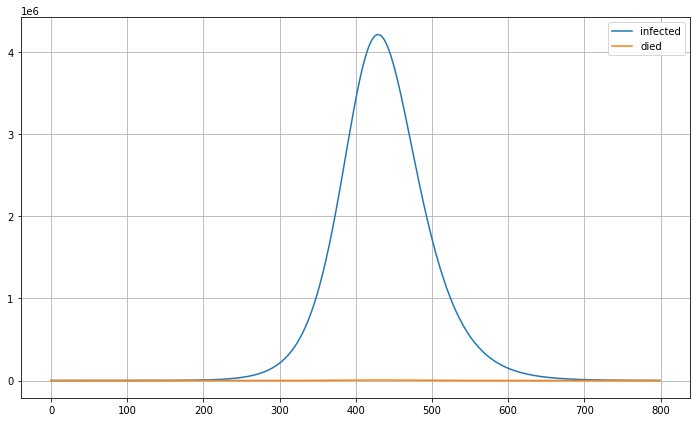

In [13]:
number_of_infected = [int(np.ceil((i) * N)) for i in It]
number_of_died = [int(np.ceil((rt) * N * died_cure_radio)) for rt in Rt]
a = [ number_of_died[i]-number_of_died[i-1] for i in range(len(number_of_died)) ]
a[0]=number_of_died[0]
# time=pd.data_range(start_time=start_time,end_time=end_time)
# time=pd.date_range(start=start_time,end=end_time,freq='D')
time=[i for i in range(800)]
plt.figure(figsize=(12,7))
plt.plot(time,number_of_infected,label='infected')
plt.plot(time,a,label='died')

plt.grid(True)
plt.legend()
plt.savefig('./img/china_pred_infected&died')
plt.show()

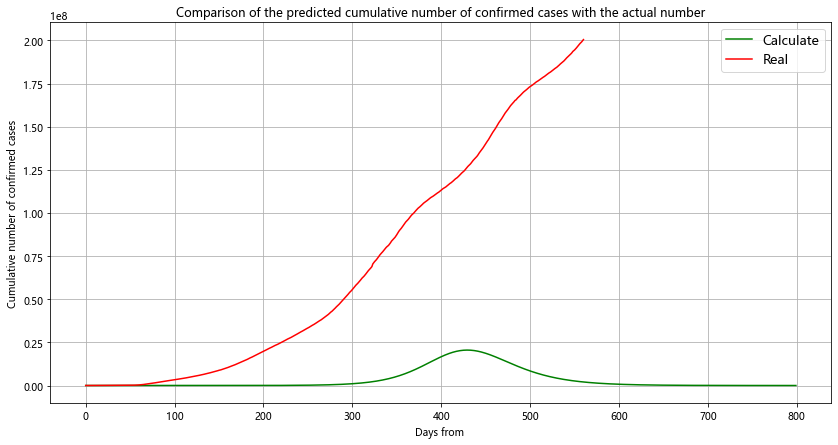

In [27]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(t, N * It, c="g", label="Calculate")
ax.plot(df1.index, df1['累计确诊'], c="r", label="Real")
ax.set_title("Comparison of the predicted cumulative number of confirmed cases with the actual number")
ax.set_xlabel('Days from '.format(start_time))
ax.set_ylabel('Cumulative number of confirmed cases')
ax.legend(fontsize=13)
ax.grid(True)
plt.show()

In [15]:
# -*- coding: utf-8 -*-
class SEIR:
    def __init__(self, T, N, E, I, R, r1, r2, b1, b2, a, g):
        self.N = N
        self.E = [E]
        self.I = [I]
        self.R = [R]
        self.S = [N-I]
        self.r1 = r1
        self.r2 = r2
        self.b1 = b1
        self.b2 = b2
        self.a = a
        self.g = g
        self.T = T
    
    def calc(self):
        if len(self.T) == len(self.S):
            return
        for i in range(0, len(self.T) - 1):
            self.S.append(self.S[i] - self.r1 * self.b1 * self.S[i] * self.I[i] / self.N - self.r2 * self.b2 * self.S[i] * self.E[i] / self.N)
            self.E.append(self.E[i] + self.r1 * self.b1 * self.S[i] * self.I[i] / self.N - self.a * self.E[i] + self.r2 * self.b2 * self.S[i] * self.E[i] / self.N)
            self.I.append(self.I[i] + self.a * self.E[i] - self.g * self.I[i])
            self.R.append(self.R[i] + self.g * self.I[i])
    
    def plot(self):
        mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 微软雅黑
        mpl.rcParams['font.serif'] = ['Microsoft YaHei']
        mpl.rcParams['axes.unicode_minus'] = False
        
        if len(self.S) == 1:
            self.calc()
        plt.figure()
        plt.title("SEIR传播时间曲线")
        plt.plot(self.T, self.S, color = 'b', label = '易感者')
        plt.plot(self.T, self.E, color = 'y', label = '潜伏者')
        plt.plot(self.T, self.I, color = 'r', label = '传染者')
        plt.plot(self.T, self.R, color = 'g', label = '康复者')
        plt.grid(False)
        plt.legend()
        plt.xlabel("时间")
        plt.ylabel("人数")
        plt.show()

In [16]:
path='./data/china_data.csv'
china_data=pd.read_csv(path)
china_data

,Unnamed: 0,日期,累计疑似
0,0,2020年1月16日,0
1,1,2020年1月17日,0
2,2,2020年1月18日,0
3,3,2020年1月19日,0
4,4,2020年1月20日,54
...,...,...,...
872,872,2022年6月6日,0
873,873,2022年6月7日,0
874,874,2022年6月8日,0
875,875,2022年6月9日,1


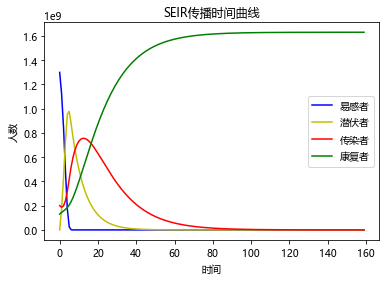

In [17]:
# df1['死亡人数'].values
T = [i for i in range(160)]
N=15e+8

I=df1['累计确诊'].values
R=df1['治愈人数'].values
E=china_data['累计疑似'].values[:R.size]

# S  易感者
# E  潜伏者
# I  传染者
# R  康复者
r1 = 21  # 传染者接触人数
r2 = 21  # 潜伏者接触人数
b1 = 0.048  # 传染者传染概率
b2 = 0.048  # 潜伏者传染概率
a = 0.13  # 潜伏者患病概率
g = 0.066  # 康复概率
s = SEIR(T, N, E[-1], I[-1], R[-1], r1, r2, b1, b2, a, g)
s.plot()

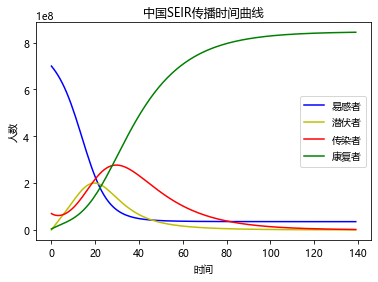

In [18]:
# -*- coding: utf-8 -*-
class SEIR_Pro:
    def __init__(self, T, N, E, I,D, R, r1, r2, b1, b2, a, g,d,Ts):
        self.N = N
        self.E = [E]
        self.I = [I]
        self.D = [D]
        self.R = [R]
        self.S = [N-I]
        self.r1 = r1
        self.r2 = r2
        self.b1 = b1
        self.b2 = b2
        self.a = a
        self.g = g
        self.T = T
        self.d =d
        self.Ts=Ts
#         self.D_sum=[D]
        self.R_day=[R]
    
    def calc(self):
        if len(self.T) == len(self.S):
            return
        for i in range(0, len(self.T) - 1):
            self.N-=self.D[i]
            self.I[i]-=self.D[i]
            self.S.append(self.S[i] - self.r1 * self.b1 * self.S[i] * self.I[i] / self.N - self.r2 * self.b2 * self.S[i] * self.E[i] / self.N+self.R_day[i]/self.Ts)
            self.E.append(self.E[i] + self.r1 * self.b1 * self.S[i] * self.I[i] / self.N - self.a * self.E[i] + self.r2 * self.b2 * self.S[i] * self.E[i] / self.N)
            self.I.append(self.I[i] + self.a * self.E[i] - self.g * self.I[i])
            self.R.append(self.R[i] + self.g * self.I[i])
            self.R_day.append(self.g * self.I[i])
            self.D.append(self.I[i] * self.d)
#             self.D_sum.append(self.D_sum[i]+self.D[i+1])
    
    def plot(self):
        mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 微软雅黑
        mpl.rcParams['font.serif'] = ['Microsoft YaHei']
        mpl.rcParams['axes.unicode_minus'] = False
        
        if len(self.S) == 1:
            self.calc()
        plt.figure()
        name="中国SEIR传播时间曲线"
        plt.title(name)
        plt.plot(self.T, self.S, color = 'b', label = '易感者')
        plt.plot(self.T, self.E, color = 'y', label = '潜伏者')
        plt.plot(self.T, self.I, color = 'r', label = '传染者')
        plt.plot(self.T, self.R, color = 'g', label = '康复者')
        
        self.D=[i for i in self.D]
        plt.grid(False)
        plt.legend()
        plt.xlabel("时间")
        plt.ylabel("人数")
        plt.savefig(f'./img/{name}')
        plt.show()
        
    # df1['死亡人数'].values
T = [i for i in range(140)]
N=9e+8

I=df1['累计确诊'].values
R=df1['治愈人数'].values
E=china_data['累计疑似'].values[:R.size]
D=df1['死亡人数'].values  #当天是我

# S  易感者
# E  潜伏者
# I  传染者
# R  康复者
# D  每日死亡
r1 = 11  # 传染者接触人数
r2 = 11  # 潜伏者接触人数
b1 = 0.018  # 传染者传染概率
b2 = 0.018  # 潜伏者传染概率
a = 0.13  # 潜伏者患病概率
g = 0.066  # 康复概率
d = 1e-3   # 感染至死率
Ts = 7   # Ts为抗体持续时间/病毒变异时间

s = SEIR_Pro(T, N, E[-1], I[-1], R[-1],D[-1], r1, r2, b1, b2, a, g,d,Ts)
s.plot()

2 200496862 130747486 4253391


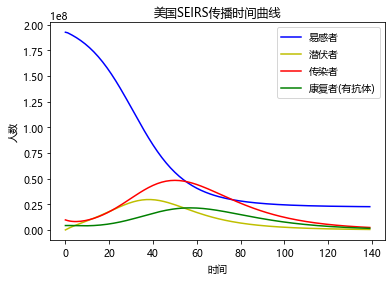

In [19]:
# -*- coding: utf-8 -*-
class SEIRS:

    def __init__(self, T, N, E, I, D, R, r1, r2, b1, b2, a, g, d, Ts):
        self.N = N
        self.E = [E]
        self.I = [I]
        self.D = [D]
        self.R = [R]
        self.S = [N - I]
        self.r1 = r1
        self.r2 = r2
        self.b1 = b1
        self.b2 = b2
        self.a = a
        self.g = g
        self.T = T
        self.d = d
        self.Ts = Ts
        #         self.D_sum=[D]
        self.R_day = [R]

    def calc(self):
        if len(self.T) == len(self.S):
            return
        for i in range(0, len(self.T) - 1):
            self.N -= self.D[i]
            self.I[i] -= self.D[i]

            self.S.append(self.S[i] -
                          self.r1 * self.b1 * self.S[i] * self.I[i] / self.N -
                          self.r2 * self.b2 * self.S[i] * self.E[i] / self.N +
                          self.R_day[i] / self.Ts)
            self.E.append(self.E[i] +
                          self.r1 * self.b1 * self.S[i] * self.I[i] / self.N +
                          self.r2 * self.b2 * self.S[i] * self.E[i] / self.N -
                          self.a * self.E[i])
            self.I.append(self.I[i] + self.a * self.E[i] - self.g * self.I[i])
            self.R.append(self.R[i] + self.g * self.I[i] - self.R[i] / self.Ts)

            self.R_day.append(self.g * self.I[i])
            self.D.append(self.I[i] * self.d)
#             self.D_sum.append(self.D_sum[i]+self.D[i+1])

    def plot(self):
        mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 微软雅黑
        mpl.rcParams['font.serif'] = ['Microsoft YaHei']
        mpl.rcParams['axes.unicode_minus'] = False

        if len(self.S) == 1:
            self.calc()
        plt.figure()
        plt.title("美国SEIRS传播时间曲线")
        plt.plot(self.T, self.S, color='b', label='易感者')
        plt.plot(self.T, self.E, color='y', label='潜伏者')
        plt.plot(self.T, self.I, color='r', label='传染者')
        plt.plot(self.T, self.R, color='g', label='康复者(有抗体)')

        self.D = [i for i in self.D]
        plt.grid(False)
        plt.legend()
        plt.xlabel("时间")
        plt.ylabel("人数")
        plt.savefig('./img/美国SEIRS传播时间曲线')
        plt.show()
        return self


# df1['死亡人数'].values
T = [i for i in range(140)]
N = 3.33e+8

I = df1['累计确诊'].values
R = df1['治愈人数'].values
E = china_data['累计疑似'].values[:R.size]
D = df1['死亡人数'].values  #当天是我

# S  易感者
# E  潜伏者
# I  传染者
# R  康复者
# D  每日死亡
r1 = 11  # 传染者接触人数
r2 = 11  # 潜伏者接触人数
b1 = 0.011  # 传染者传染概率
b2 = 0.011  # 潜伏者传染概率
a = 0.13  # 潜伏者患病概率(1/疾病潜伏期)
g = 0.066  # 康复概率
d = 1e-3  # 感染至死率
Ts = 7  # Ts为抗体持续时间/病毒变异时间
print(E[-1], I[-1], R[-1], D[-1])
s = SEIRS(T, N, E[-1], 140496862, R[-1], D[-1], r1, r2, b1, b2, a, g, d, Ts)
s.plot()

<function matplotlib.pyplot.show(close=None, block=None)>

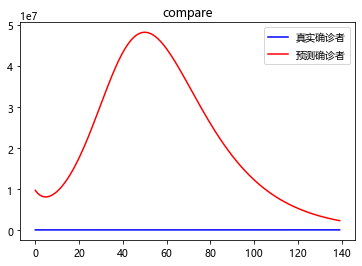

In [21]:
confimed_china_path='./data/confirmed_china.csv'
confimed_china=pd.read_csv(confimed_china_path)
plt.figure()
plt.title('compare')
plt.plot(s.T,confimed_china['confirmed'].values[:140], color = 'b', label = '真实确诊者')
plt.plot(s.T,s.I,color='r',label='预测确诊者')
plt.legend()
plt.show